In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('ignition_topography_data.csv')

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

low_thresh = 0.1
high_thresh = 1.0

def classify_severity(fsr):
    if fsr < low_thresh:
        return 'low_severity'
    elif fsr < high_thresh:
        return 'medium_severity'
    else:
        return 'high_severity'

df['severity_class'] = df['fsr_km2_dy'].apply(classify_severity)
le_severity = LabelEncoder()
df['severity_encoded'] = le_severity.fit_transform(df['severity_class'])

if df['land_cover'].dtype == 'object':
    le_lc = LabelEncoder()
    df['land_cover_encoded'] = le_lc.fit_transform(df['land_cover'])
else:
    df['land_cover_encoded'] = df['land_cover']

if 'ecoregion' in df.columns and df['ecoregion'].dtype == 'object':
    le_eco = LabelEncoder()
    df['ecoregion_encoded'] = le_eco.fit_transform(df['ecoregion'])
else:
    df['ecoregion_encoded'] = df['ecoregion']

elevation_features = [
    'ignition_elev', 'mean_elev', 'min_elev', 'max_elev',
    'std_elev', 'range_elev', 'ignition_slope_deg', 'ignition_slope_pct'
]

categorical_features = ['land_cover_encoded', 'ecoregion_encoded'] if 'ecoregion_encoded' in df.columns else ['land_cover_encoded']

features = [f for f in elevation_features + categorical_features if f in df.columns]
X = df[features]
y = df['severity_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Naive Bayes

Gaussian Naive Bayes Classification Report:
                 precision    recall  f1-score   support

  high_severity       0.00      0.00      0.00      3632
   low_severity       0.00      0.00      0.00      1616
medium_severity       0.92      1.00      0.96     63645

       accuracy                           0.92     68893
      macro avg       0.31      0.33      0.32     68893
   weighted avg       0.85      0.92      0.89     68893



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


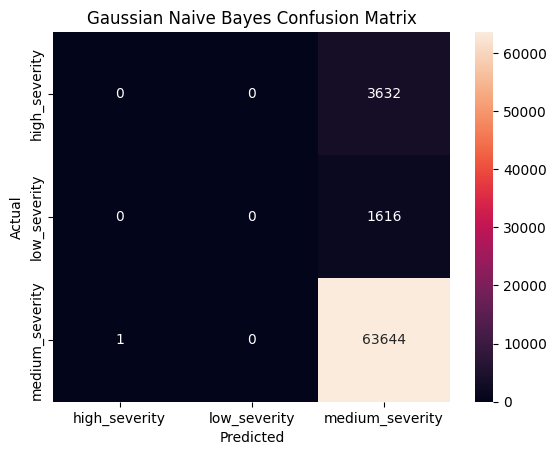

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns


gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_preds = gnb.predict(X_test)

print("Gaussian Naive Bayes Classification Report:")
print(classification_report(y_test, gnb_preds, target_names=le.classes_))

cm = confusion_matrix(y_test, gnb_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Gaussian Naive Bayes Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier



rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)



In [9]:
print(classification_report(y_test, rf_preds, target_names=le.classes_))

                 precision    recall  f1-score   support

  high_severity       0.21      0.03      0.05      3632
   low_severity       0.09      0.00      0.01      1616
medium_severity       0.93      0.99      0.96     63645

       accuracy                           0.92     68893
      macro avg       0.41      0.34      0.34     68893
   weighted avg       0.87      0.92      0.89     68893



# XGBoost

In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print(classification_report(y_test, xgb_preds, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


                 precision    recall  f1-score   support

  high_severity       0.33      0.00      0.00      3632
   low_severity       0.00      0.00      0.00      1616
medium_severity       0.92      1.00      0.96     63645

       accuracy                           0.92     68893
      macro avg       0.42      0.33      0.32     68893
   weighted avg       0.87      0.92      0.89     68893



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Class balancing

In [12]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", Counter(y_train_bal))


Class distribution after SMOTE: Counter({2: 253577, 0: 253577, 1: 253577})


In [14]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

clf_preds = rf.predict(X_test)



In [15]:
print(classification_report(y_test, clf_preds, target_names=le.classes_))

                 precision    recall  f1-score   support

  high_severity       0.21      0.03      0.05      3632
   low_severity       0.09      0.00      0.01      1616
medium_severity       0.93      0.99      0.96     63645

       accuracy                           0.92     68893
      macro avg       0.41      0.34      0.34     68893
   weighted avg       0.87      0.92      0.89     68893

